In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import cv2
import os 
from matplotlib.image import imread


from tensorflow.keras.utils import to_categorical



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
#from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import LearningRateScheduler
from keras.applications.vgg16 import VGG16, preprocess_input

 

#### Creating Training and Test Dataset

In [3]:
##collecting the train image list and test image list
#tr_img_list_dir = os.listdir("drive/My Drive/apmproject/images/train/

tr_img_list = pd.read_csv("drive/My Drive/apmproject/images/train/driver_imgs_list.csv")
tr_img_list

subject classname            img
0        p002        c0  img_44733.jpg
1        p002        c0  img_72999.jpg
2        p002        c0  img_25094.jpg
3        p002        c0  img_69092.jpg
4        p002        c0  img_92629.jpg
...       ...       ...            ...
22419    p081        c9  img_56936.jpg
22420    p081        c9  img_46218.jpg
22421    p081        c9  img_25946.jpg
22422    p081        c9  img_67850.jpg
22423    p081        c9   img_9684.jpg

[22424 rows x 3 columns]

In [59]:
## checking the size of all the images 

dim1 =[]
dim2 = []
train_pointr = "drive/My Drive/apmproject/images/train/"
for i in range(tr_img_list.shape[0]):    
    img_nme = tr_img_list.loc[i,["classname"]].values+"/" + tr_img_list.loc[i,["img"]].values
    img_addr = train_pointr+img_nme
    img = imread(img_addr[0])
    dim1shape,dim2shape,color = img.shape
    dim1.append(dim1shape)
    dim2.append(dim2shape)


dim1[:5]
    

[480, 480, 480, 480, 480]

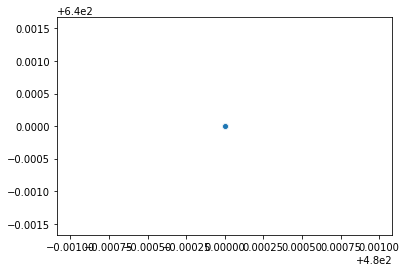

In [115]:
sns.scatterplot(dim1,dim2)

since the above plot shows only one point, thus every image is of same shape, and we don't need to control for different image sizes 

In [6]:
## loading some sample images to see their orientation nand other properties
d = os.listdir("drive/My Drive/apmproject/images/train/")

imgsample = []
train_pointr = "drive/My Drive/apmproject/images/train/"
#or i in range(tr_img_list.shape[0]):    
for i in range(10):
    ## generating a random row index
    #np.random.seed(40)
    tble_indx = np.random.randint(1,20000)
    ##Calling that image from the training file 
    #mg_nme = tr_img_list.loc[i,["classname"]].values+"/" + tr_img_list.loc[i,["img"]].values
    img_nme = tr_img_list.loc[tble_indx,["classname"]].values+"/" + tr_img_list.loc[tble_indx,["img"]].values
    ##concating the address of the image and taking only the value from the resulting array
    img_addr = train_pointr+img_nme
    img = imread(img_addr[0])
    ##appending the images 
    imgsample.append(img)



    

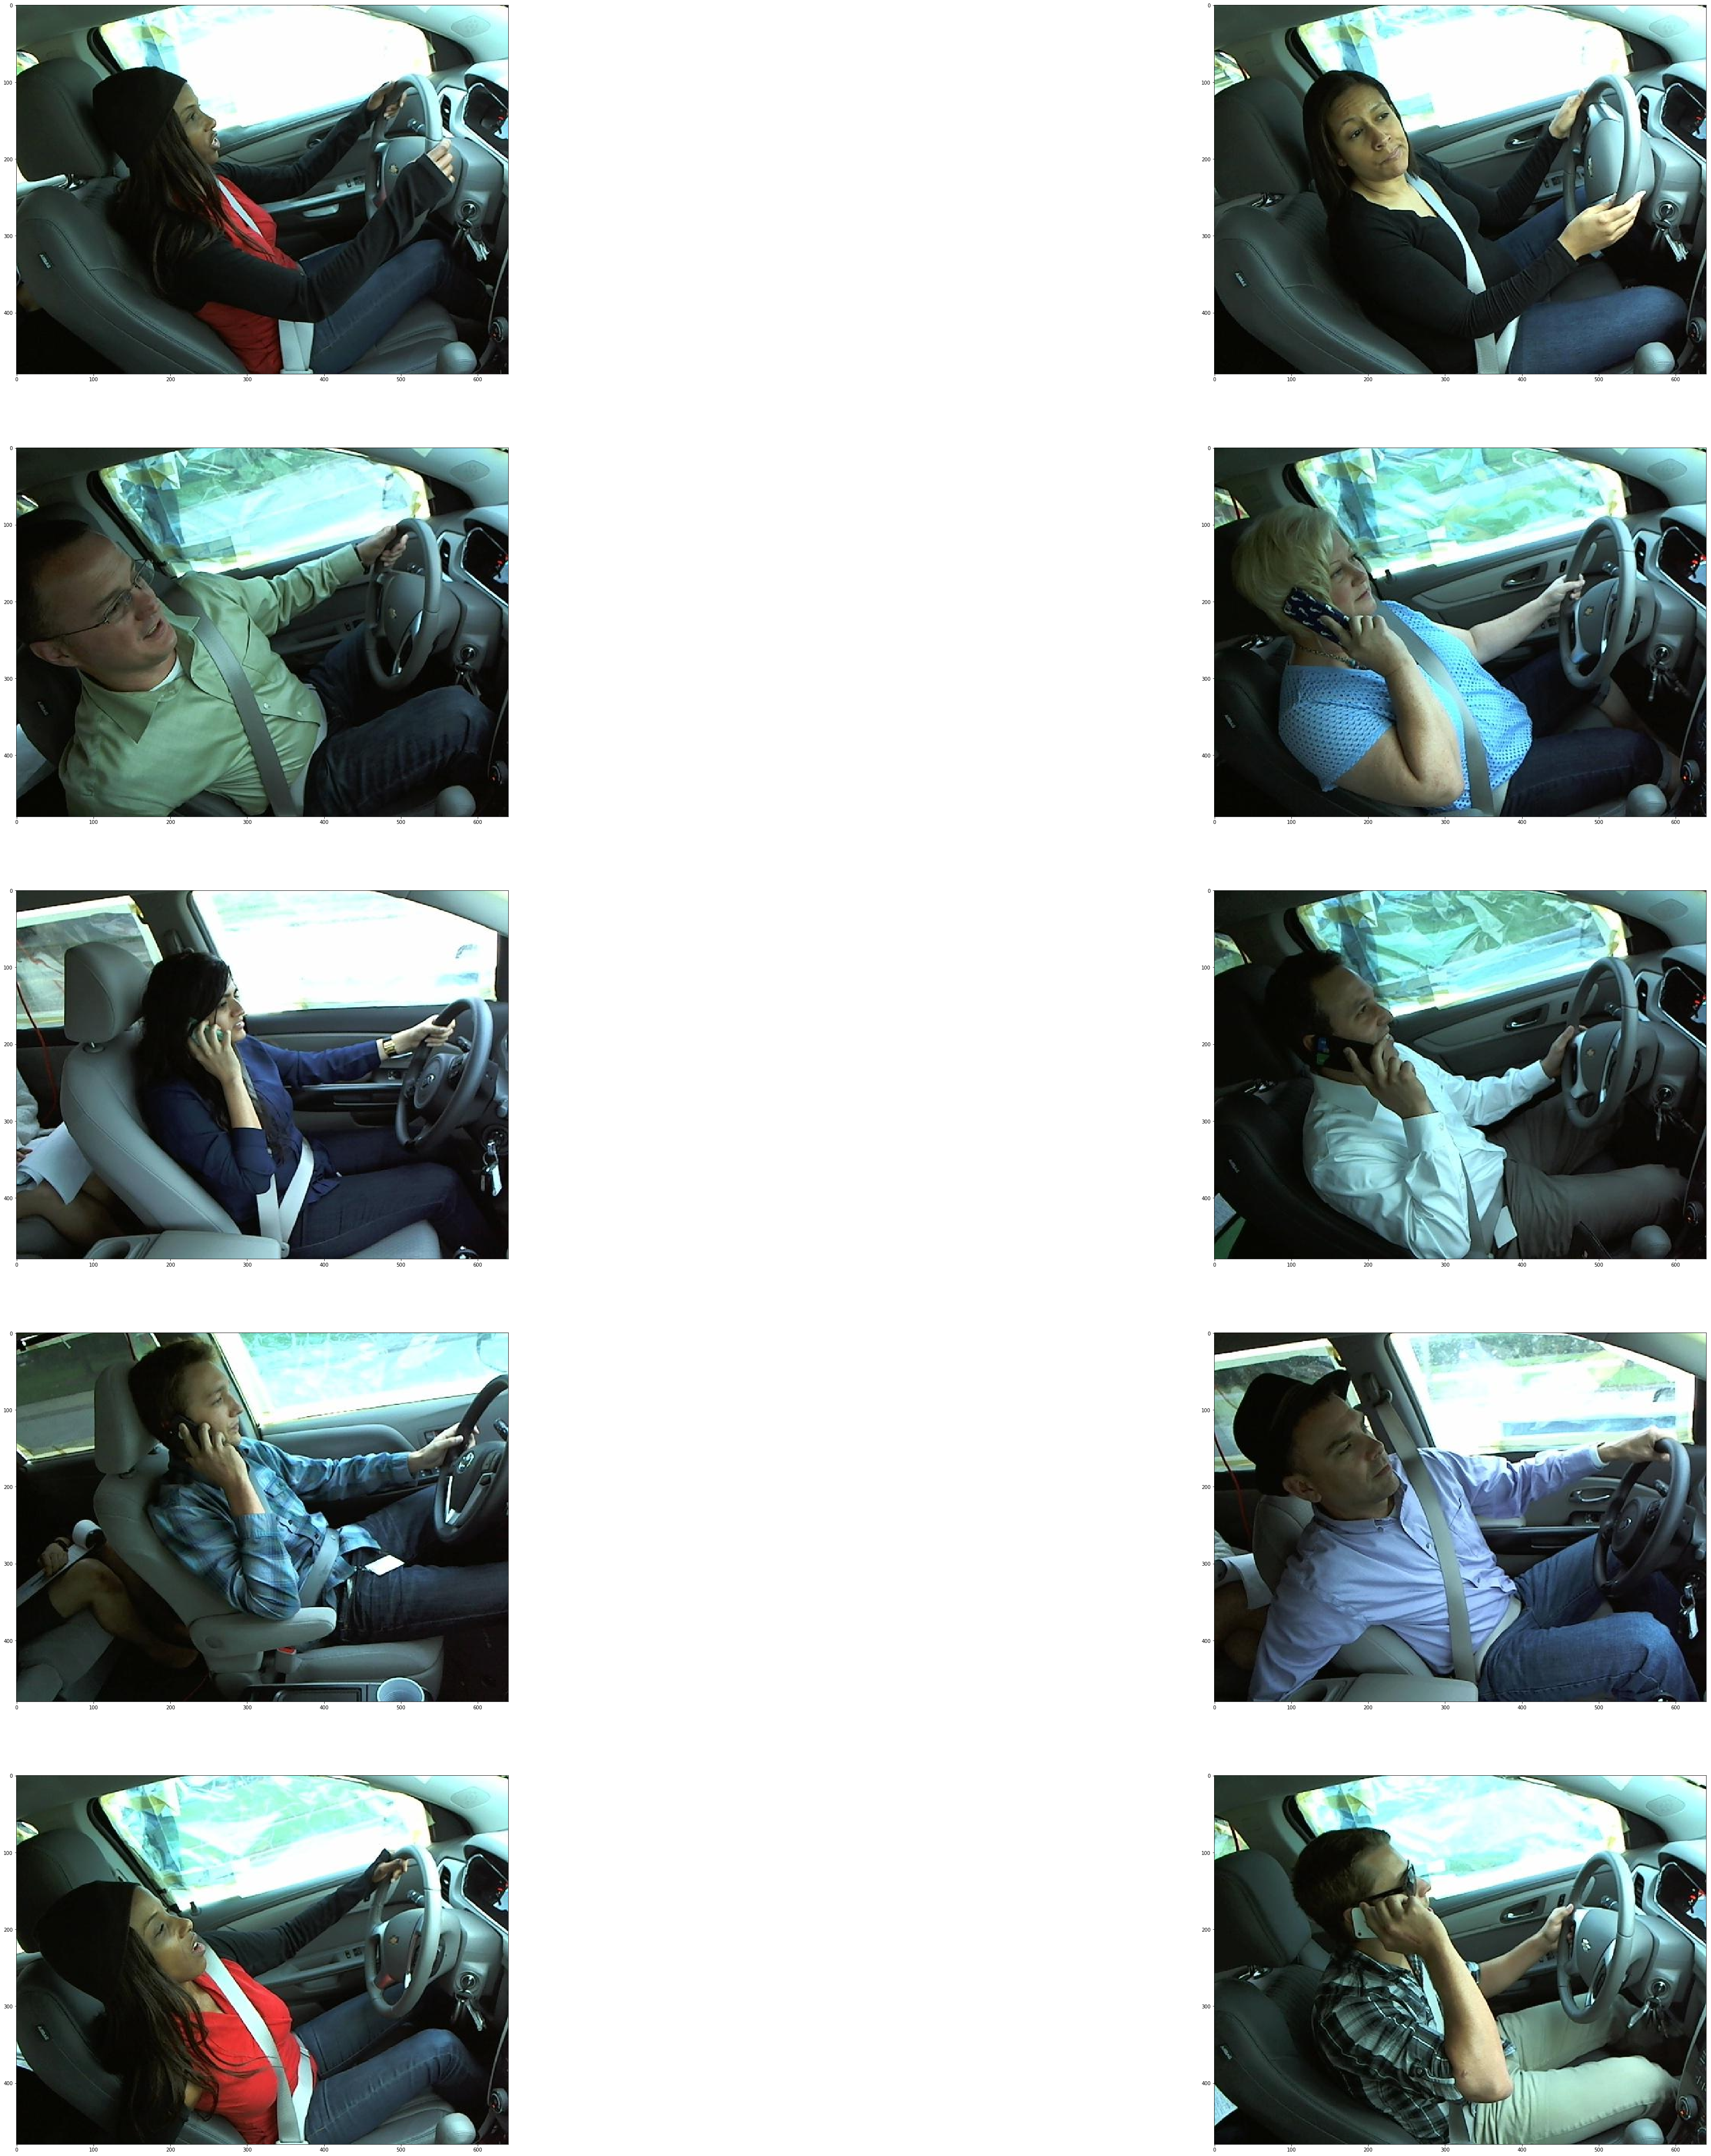

In [283]:
fig,axes = plt.subplots(nrows = 5, ncols = 2, figsize=(80,80), squeeze = False, sharex = False, sharey = False)

for i in range(len(imgsample)):
       axes.flatten()[i].imshow(imgsample[i])
    
plt.show()
    
 

The images also look the same, thus no extra effort is required in terms of shifting.

We would now be implementing the model along with Class Activation Maps to see where the model is paying attention to in our image in order to classify it differently.

This technique for Class Activation Function is really uselful and provides more information rather than just visualizating the gradients and pattenrs of individual layers in a Convv network. For example, a simple cat vs dog classification, this CAM technique tell help you understand what parts of dogs and cats is your model using to classify it accordingly. Suppose the model identifies a cat majorly by its ear, so more weights would be given to those regions where the ears lie. Thus using CAM function we will be able to visually see that the regions near the ear are highlighted with more weights when it comes to the class "cat"

The method of seeing the significant weights for classification works great however, there is a slight modification which is required to be done when working with CNN. In order to get the CAM results, we apply a GlobalAveragePooling layer at the very end of the network. The main intuition behind it is to get a signle weight per unit at the end of the network which can be traced back and visualized. Since the weights in the pooling layer are resulting from the network behind, we can get a sense of what different regions is the network collectively targeting upon in different classes. 

Following model which is being loaded constitutes something similar to VGG16 used in the project "Driver Detection".The two main differences being:

1). We have applied GlobalAveragePooling and dense layer at the end.

2). We have trained it for lesser number of epochs,classes and batch-size as it is for demonstration purposes


In [18]:
from keras.models import load_model
model = load_model('model2.h5')
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 512)         262656    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 14,978,370
Non-trainable params: 0
_________________________________________________________________


In [170]:
from keras import backend as K

##Defining the output layer which will give the of the last convolution layer. Inputs are the model_name and the last layer name 
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    print(layer)
    return layer


## defining the function of CAM 
def visualize_class_activation_map(model1, img_path):
        #initializing the model, and the image path to read the image and make predictions
        model = model1
        original_img = plt.imread(img_path, 1)
        original_img = cv2.resize(original_img,(224,224))
        ##taking the width and height in seperate variable which will be used later to resize the image back 
        width, height, _ = original_img.shape

        #Reshaping the image to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        #Getting the 512 input weights to the dense layer which is provided by the global average pooling layer preceding it.
        #It is a similar process of getting the weights/gradients of the globalaveragepooling layer
        class_weights = model.layers[-1].get_weights()[0]
        ##calling the output layer function to get the final output of convv layer. 
        final_conv_layer = get_output_layer(model, "conv2d_3")
        ## here we are using the backend function, which deals with modifying the tensors behind the KERAS programming
        ## Here it is used to create a function to get the tensor of our model's convoluted output 2d_3 with respect to the input image provided
        ## It also gets the probabilities of the two classes 
        get_output = K.function([model.layers[0].input], [final_conv_layer.output])
        img = img.reshape(1,224,224,3)
        ## Seperating out the output and reshaping accordingly
        [conv_outputs] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]
        
        #Create the class activation map.
        #creating a zero array of the same shape and adding weighted output of the original image 
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        for i, w in enumerate(class_weights[:, 1]):
          cam += w * conv_outputs[ :, :,i]
        
        ##making the threshold for evaluation
        thres = np.mean(cam)

        ##editing the image to get the active regions
        cam /= np.max(cam)
        cam = cv2.resize(cam, (height, width))
        img = original_img.copy() 
        img[np.where(cam < thres)] = 100
        plt.imshow(img)
    




In [172]:
from tensorflow.keras.preprocessing import image as imgs
train_pointr = "drive/My Drive/apmproject/images/train/"
img_nme = tr_img_list.loc[20,["classname"]].values+"/" + tr_img_list.loc[20,["img"]].values
print("following is the image from the first class \n")
img_name_array = train_pointr+img_nme
img_name = img_name_array[0]
print(img_name)


following is the image from the first class 

drive/My Drive/apmproject/images/train/c0/img_66355.jpg


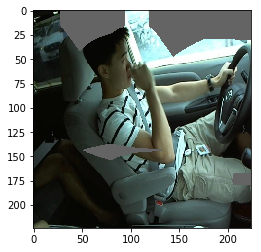

In [76]:
visualize_class_activation_map(model,img_name)

In [173]:
#from tensorflow.keras.preprocessing import image as imgs
train_pointr = "drive/My Drive/apmproject/images/train/"
img_nme = tr_img_list.loc[100,["classname"]].values+"/" + tr_img_list.loc[100,["img"]].values
print("following is the image from the second class \n")
img_name_array = train_pointr+img_nme
img_name = img_name_array[0]
print(img_name)


following is the image from the second class 

drive/My Drive/apmproject/images/train/c1/img_54734.jpg


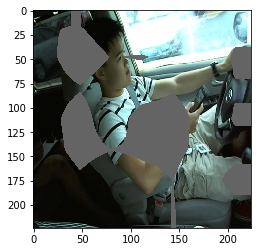

In [174]:
visualize_class_activation_map(model,img_name)

The first image corresponds to class "safe driving" and second image corresponds to "texting" 


As we can see the target regions in both the classes the model is judging whether the driver is driving safely or he is using the mobile 

In first image, classified as safe driving, we can see the regions being targeted are near the face and steering wheels


In class 1, to identify whether the person is holding a mobile phone on not, it is targeting the closer hand area and the hand near the steering wheel and the back head area(probably to guess the angle). Thus, for class "texting" the model is paying a lot more attention near the mobile region

Thus, through this we can visualize what different regions the model is pays attention to in different classes. Probably with more training it can target better and produce more accurate results but this technique can definitely help in various applications of KERAS for intuition and business purposes. 
